In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("upload/index_1.csv")
df.head(5)

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assume df is already loaded with columns ['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name']

# Step 1: Parse the datetime if not already
if not np.issubdtype(df['datetime'].dtype, np.datetime64):
    df['datetime'] = pd.to_datetime(df['datetime'])

# Step 2: Group by month and coffee sales (assuming 'money' is sales amount or 'card' + 'cash_type' columns)
# Here, we assume 'money' tracks monetary sales. If 'coffee_name' is per cup, group accordingly.
monthly_sales = df.groupby(pd.Grouper(key='datetime', freq='D'))['money'].sum()

# Step 3: Use the last year (12 months) as training data
last_12_months = monthly_sales.last('365D')

# Step 4: Fit SARIMA (seasonal ARIMA model)
# (order and seasonal_order can be tuned)
model = SARIMAX(last_12_months, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Step 5: Forecast sales for next month
forecast = model_fit.forecast(steps=1)
print("Predicted coffee sales for next day:", forecast.iloc[0])


Predicted coffee sales for next month: 414.0985299141996


In [11]:
# Calculate 7-day moving average of daily sales
moving_avg = monthly_sales.rolling(window=7, min_periods=1).mean()


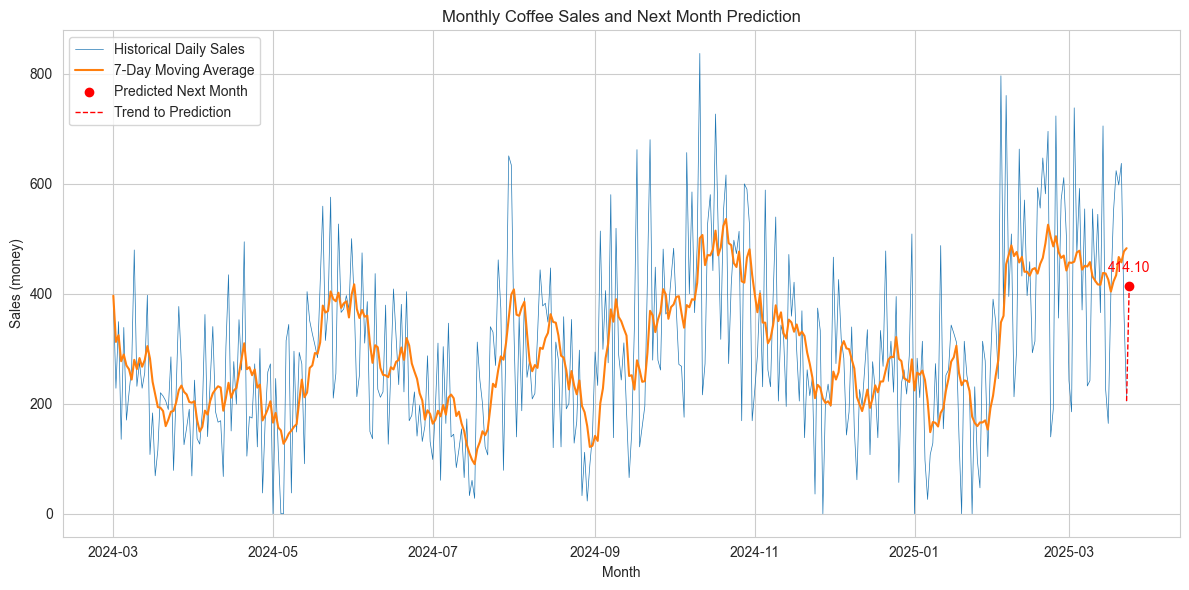

In [15]:
import matplotlib.pyplot as plt

# Plot historical monthly sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values,lw=0.5, label='Historical Daily Sales')


plt.plot(moving_avg.index, moving_avg.values,lw=1.5, label='7-Day Moving Average')

# Plot the predicted next month's sales
# Compute the timestamp for the prediction
next_month = monthly_sales.index[-1] + pd.offsets.Day(1)

plt.scatter(next_month, forecast.iloc[0], color='red', label='Predicted Next Month', zorder=5)
plt.plot([monthly_sales.index[-1], next_month], [monthly_sales.iloc[-1], forecast.iloc[0]], 
         'r--', lw=1, label='Trend to Prediction')

# Annotate the prediction
plt.annotate(f"{forecast.iloc[0]:.2f}", (next_month, forecast.iloc[0]), 
             textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=10)

plt.title("Monthly Coffee Sales and Next Month Prediction")
plt.xlabel("Month")
plt.ylabel("Sales (money)")
plt.legend()
plt.tight_layout()
plt.show()


Predicted most sold coffee for next month: Americano
Predicted sales: 119.50000874999563


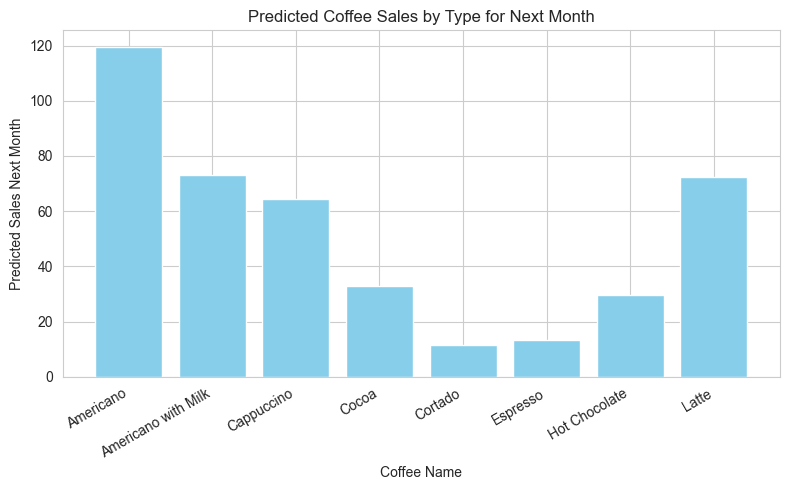

In [9]:
# Predict the most sold coffee for next month

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare data: group by month and coffee_name, aggregate counts
monthly_coffee_sales = df.groupby([pd.Grouper(key='datetime', freq='M'), 'coffee_name']).size().unstack(fill_value=0)

# Take the last 12 months as training data
last_12_months_coffee = monthly_coffee_sales.tail(12)

# Fit SARIMA for each coffee type and predict next month's sales
predictions = {}
for coffee in last_12_months_coffee.columns:
    series = last_12_months_coffee[coffee]
    # Handle all-zero columns or insufficient data
    # If sum is 0, skip
    if series.sum() == 0 or series.count() < 2:
        predictions[coffee] = 0
        continue
    try:
        model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
        model_fit = model.fit(disp=False)
        pred = model_fit.forecast(steps=1).iloc[0]
        predictions[coffee] = pred if pred > 0 else 0
    except:
        predictions[coffee] = 0  # fallback

# Find the coffee with the highest predicted sales
most_sold_coffee = max(predictions, key=predictions.get)
print("Predicted most sold coffee for next month:", most_sold_coffee)
print("Predicted sales:", predictions[most_sold_coffee])

# (Optional) Show a bar chart of all predictions
plt.figure(figsize=(8, 5))
plt.bar(predictions.keys(), predictions.values(), color='skyblue')
plt.xlabel('Coffee Name')
plt.ylabel('Predicted Sales Next Month')
plt.title('Predicted Coffee Sales by Type for Next Month')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [22]:
print(df['coffee_name'].value_counts())
df['new_coffee_name'] = df['coffee_name'].str.replace('Americano with Milk', 'Americano')
df['new_coffee_name'] = df['new_coffee_name'].str.replace('Cocoa', 'Hot Chocolate')

df['new_coffee_name'].value_counts()


Americano with Milk    824
Latte                  782
Americano              578
Cappuccino             501
Cortado                292
Hot Chocolate          282
Cocoa                  243
Espresso               134
Name: coffee_name, dtype: int64


Americano        1402
Latte             782
Hot Chocolate     525
Cappuccino        501
Cortado           292
Espresso          134
Name: new_coffee_name, dtype: int64

In [24]:
# Build a predictor for which drink to promote each day to maximize profit

# Assumptions:
# 1. Each drink has a profit margin, e.g., profit_per_drink as a mapping.
# 2. For each date, predict which coffee would most benefit from promotion, e.g., based on lower past sales but higher profit margin.
# 3. "Promotion" target is the drink where an increase in sales would most boost profit, i.e., (Potential_for_Growth x Profit_Margin).

# Example hypothetical profit margins (should come from data or business logic in practice)
profit_per_drink = {
    'Latte': 2.5,
    'Americano': 2.0,
    'Hot Chocolate': 2.8,
    'Espresso': 1.7,
    'Cappuccino': 2.2,
    # 'Americano with Milk': 2.0,
    # 'Cocoa': 2.5,
    'Cortado': 2.3
    # ... add all available coffee_name's from df
}
# Update with all unique coffee_name from the data if needed:
for name in df['new_coffee_name'].unique():
    if name not in profit_per_drink:
        profit_per_drink[name] = 2.0  # default profit if missing

# Calculate daily drink sales
daily_coffee_sales = df.groupby(['date', 'new_coffee_name']).size().unstack(fill_value=0)

# Calculate the rolling 7-day average sales for each drink to get a "trend"
rolling_avg = daily_coffee_sales.rolling(window=7, min_periods=1).mean()

# Calculate overall daily profit per drink (for context/visualization)
daily_profit = daily_coffee_sales * daily_coffee_sales.columns.map(profit_per_drink)

# Main logic: for each day, pick the drink with both (a) low sales (room for promotion impact) and (b) high profit margin
# We'll score each drink as: (max_rolling_avg - today's sales) * profit_per_drink
promotion_targets = {}
for day in daily_coffee_sales.index:
    today_sales = daily_coffee_sales.loc[day]
    trend = rolling_avg.loc[day]
    # The higher the "gap" between trend and today's sales, the more room for uplift
    gap = trend.max() - today_sales
    score = gap * today_sales.index.map(lambda x: profit_per_drink.get(x, 2.0))
    # If all drinks have sales close to trend (e.g., at max), just rely on profit margin
    if (score <= 0).all():
        score = today_sales.index.map(lambda x: profit_per_drink.get(x, 2.0))
    # Select drink with highest score
    drink_to_promote = score.idxmax()
    promotion_targets[day] = drink_to_promote

# Show results for the next 7 days (if data exists) or for the latest available dates
print("Recommended promotion drink per day (top 7 latest):")
for day in list(promotion_targets)[-7:]:
    print(f"{day}: Promote '{promotion_targets[day]}'")

# Optional: Display as DataFrame for easier use
promotion_recommendations = pd.DataFrame(
    {'recommended_drink': pd.Series(promotion_targets)}
)
display(promotion_recommendations.tail(14))



Recommended promotion drink per day (top 7 latest):
2025-03-17: Promote 'Cortado'
2025-03-18: Promote 'Cortado'
2025-03-19: Promote 'Hot Chocolate'
2025-03-20: Promote 'Latte'
2025-03-21: Promote 'Hot Chocolate'
2025-03-22: Promote 'Cortado'
2025-03-23: Promote 'Cortado'


,recommended_drink
2025-03-10,Cortado
2025-03-11,Cortado
2025-03-12,Cortado
2025-03-13,Hot Chocolate
2025-03-14,Cortado
2025-03-15,Hot Chocolate
2025-03-16,Hot Chocolate
2025-03-17,Cortado
2025-03-18,Cortado
2025-03-19,Hot Chocolate


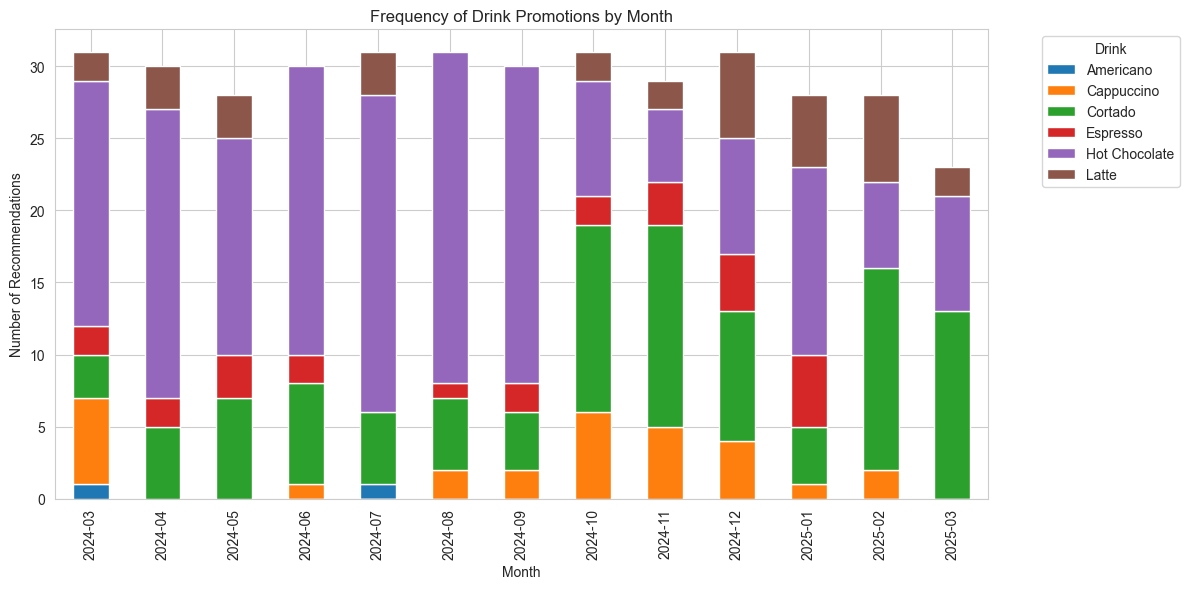

In [25]:
import matplotlib.pyplot as plt

# Ensure that the index is a datetime if not already
promotion_recommendations = promotion_recommendations.copy()
promotion_recommendations.index = pd.to_datetime(promotion_recommendations.index)

# Extract year-month from index; group and count occurrences of each drink per month
per_month = (
    promotion_recommendations
    .assign(month=promotion_recommendations.index.to_period('M'))
    .groupby(['month', 'recommended_drink'])
    .size()
    .unstack(fill_value=0)
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
per_month.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel("Number of Recommendations")
ax.set_xlabel("Month")
ax.set_title("Frequency of Drink Promotions by Month")
ax.legend(title="Drink", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
